In [1]:
import itertools
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from IPython.display import HTML, Markdown, display

MEASUREMENTS_FOLDER = "MSE logs"

setting_names = set(
    [
        "texture size",
        "downscale",
        "number of clusters",
        "number of iterations",
        "random swap",
        "randomize empty clusters",
        "KHM",
        "staggered jitter",
        "jitter size",
        "video file",
    ]
)

def load_measurements(measurement_name: str):
    log_file_names = os.listdir(f"{MEASUREMENTS_FOLDER}/{measurement_name}")
    
    def setting_transform(value):
        match value:
            case "True":
                return "Yes"
            case "False":
                return "No"
        return value

    measurements = [
        {
            "settings" : {
                setting_name : setting_transform(setting_value)
                    for setting_name, setting_value in [
                            setting_text.split(':')
                                for setting_text in file_name.split('.')[0].split("|")
                        ]
            },
            "MSE" : pd.read_csv(
                f"{MEASUREMENTS_FOLDER}/{measurement_name}/{file_name}"
            )["MSE"].tolist()[10:-10], # first and lust 10 frames removed
            "file name" : file_name
        }
        for file_name in log_file_names
    ]
    
    for measurement in measurements:
        assert (
            set(
                measurement["settings"].keys()
            ) == set(
                setting_names
            )
        )
    
    for measurement in measurements:
        measurement["total MSE"] = sum(measurement["MSE"]) / len(measurement["MSE"])
    
    for measurement in measurements:
        measurement["maximum MSE"] = max(measurement["MSE"])
    
    return measurements

def show_measurements_table(measurements):    
    def get_setting_value_lengths(measurements):
        return {
            setting_name : max(
                max(
                    [
                        len(measurement['settings'][setting_name])
                            for measurement in measurements
                    ]
                ),
                len(setting_name)
            )
            for setting_name in setting_names
        }
    
    def get_settings_same_everywhere(measurements):
        def is_setting_same_everywhere(setting_name):
            for measurement in measurements:
                if measurement["settings"][setting_name] != measurements[0]["settings"][setting_name]:
                    return False
            return True
        return [setting_name for setting_name in setting_names if is_setting_same_everywhere(setting_name)]
    
    setting_value_lengths = get_setting_value_lengths(measurements)
    settings_same_everywhere = get_settings_same_everywhere(measurements)
    
    def print_setting(name, value):
        print(value, end="")
        print(
            " " * (
                setting_value_lengths[name] - len(value)
            ),
            end=""
        )


    for setting_name in setting_names:
        if setting_name in settings_same_everywhere:
            continue
        print(setting_name, end="")
        print("  |  ", end="")
    print("MSE")
    print("-" *
        (
            sum(
                [
                    setting_value_lengths[name] + 5
                    for name in setting_names
                    if not name in settings_same_everywhere
                ]
            ) + 8
        )
    )

    for measurement in measurements:
        for setting_name in setting_names:
            if setting_name in settings_same_everywhere:
                continue
            print_setting(setting_name, measurement['settings'][setting_name])
            print("  |  ", end="")
        total_mse_string = f"{measurement['total MSE']:0.5f}"
        print(f'{total_mse_string:10}', end="")
        print()

In [2]:
def plot_diff(index1, index2):    
    diff = [
        a - b for a,b in zip(
            logs[index1]["MSE"],
            logs[index2]["MSE"]
        )
    ]
    
    _, ax = plt.subplots()
    
    sb.lineplot(
        x=logs[index1]["Frame"],
        y=diff,
        ax=ax,
        label=f"{names[index1]} -\n{names[index2]}"
    )    
    plt.ylabel("ΔMSE")
    
    plt.show() # display plots RIGHT NOW
    
def plot_log(indices, do_plot_diff = False):    
    _, ax = plt.subplots()
    
    for logIndex in indices:
        sb.lineplot(
            x=logs[logIndex]["Frame"],
            y=logs[logIndex]["MSE"],
            ax=ax,
            label=names[logIndex]
        )
    
    if do_plot_diff:
        assert(len(indices) == 2)
        plot_diff(indices[0], indices[1])
    
    plt.show() # display plots RIGHT NOW

In [3]:
def init_seaborn():
    sb.set(
        font_scale=1.2,
        rc={
            "figure.figsize":(14, 6)
        },
        palette="deep"
    )

init_seaborn()

In [4]:
display(Markdown("## Dataser 1: iterations vs clusters"))

M1 = load_measurements("1. iterations vs clusters")

M1 = sorted(
    M1,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        int(measurement["settings"]["number of clusters"]),
        int(measurement["settings"]["number of iterations"]),
    )
)


show_measurements_table(M1)

## Dataser 1: iterations vs clusters

number of iterations  |  video file  |  MSE
------------------------------------------------
1                     |  1           |  0.01556   
2                     |  1           |  0.01546   
3                     |  1           |  0.01545   
4                     |  1           |  0.01546   
5                     |  1           |  0.01525   
6                     |  1           |  0.01525   
1                     |  2           |  0.00437   
2                     |  2           |  0.00433   
3                     |  2           |  0.00430   
4                     |  2           |  0.00426   
5                     |  2           |  0.00425   
6                     |  2           |  0.00424   
7                     |  2           |  0.00423   
8                     |  2           |  0.00423   
9                     |  2           |  0.00422   
10                    |  2           |  0.00421   
11                    |  2           |  0.00421   
12                    |  2           |  

### K-Means iterations vs clusters


#### Knecht et al. stoppind condition

* stop if variance = $10^{-4}$
* if did not converge after 20 iterations => new random initialization
* force random initialization every $5$th frame to avoid local minimum
        

#### Video 1

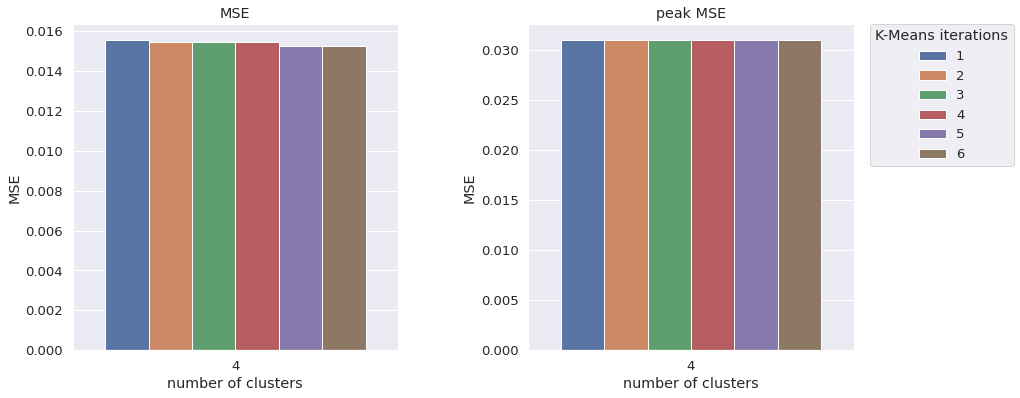

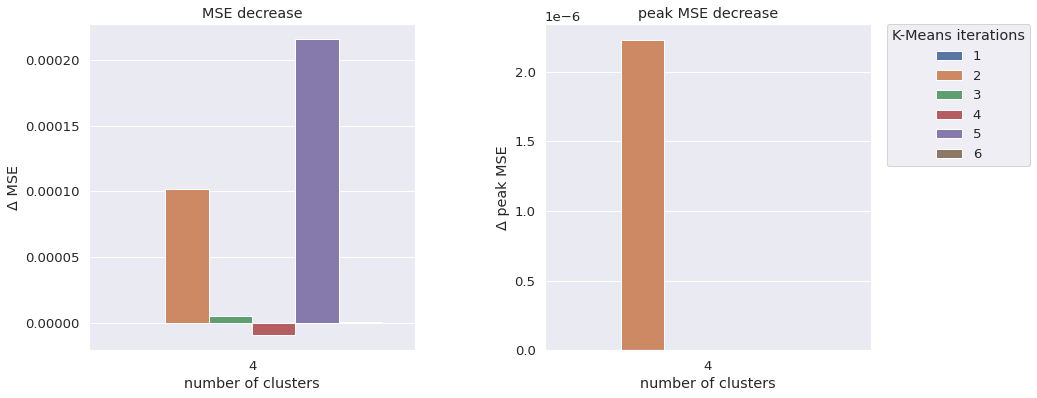

#### Video 2

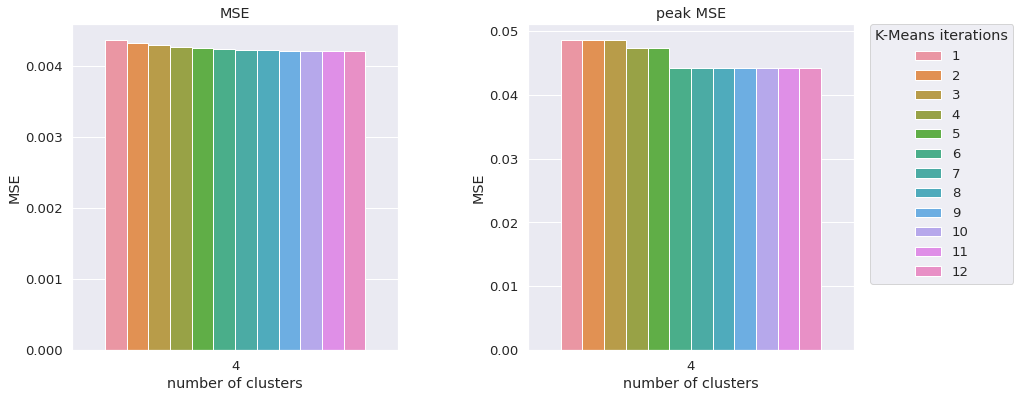

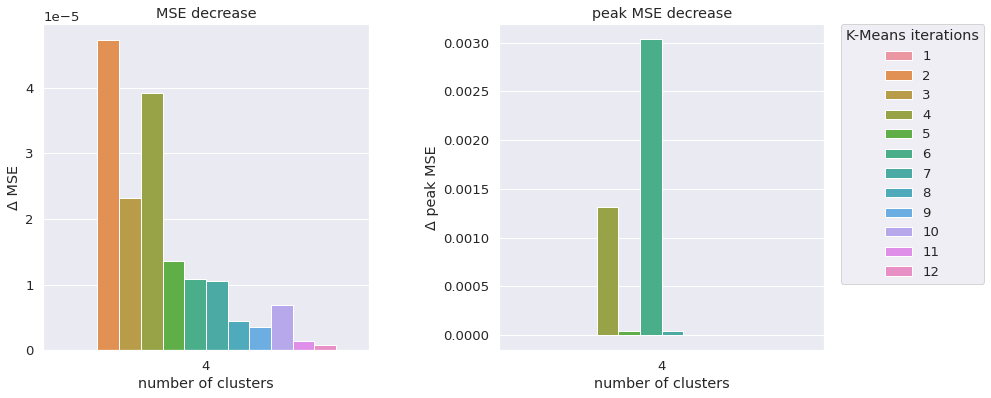

In [5]:
display(Markdown("### K-Means iterations vs clusters"))

display(
    Markdown(
        """
#### Knecht et al. stoppind condition

* stop if variance = $10^{-4}$
* if did not converge after 20 iterations => new random initialization
* force random initialization every $5$th frame to avoid local minimum
        """
    )
)

def jitter_plots():

    max_texture_size = 16
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    measurement['total MSE'],
                    measurement['maximum MSE'],
                    int(measurement['settings']['number of iterations']),
                    int(measurement['settings']['number of clusters'])
                )
                    for measurement in M1
                        if measurement['settings']["video file"] == video_name
            ],
            columns=["total MSE", "maximum MSE", "iterations", "clusters"]
        )



    total_mse_by_texture_size_with_jitter = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }
    
    for video in total_mse_by_texture_size_with_jitter:
        for i in range(1, len(total_mse_by_texture_size_with_jitter[video]["total MSE"])):
            total_mse_by_texture_size_with_jitter[video].loc[i, "total MSE decrease"] = (
                total_mse_by_texture_size_with_jitter[video].loc[i-1, "total MSE"] -
                total_mse_by_texture_size_with_jitter[video].loc[i, "total MSE"]
            )
            
    for video in total_mse_by_texture_size_with_jitter:
        for i in range(1, len(total_mse_by_texture_size_with_jitter[video]["maximum MSE"])):
            total_mse_by_texture_size_with_jitter[video].loc[i, "maximum MSE decrease"] = (
                total_mse_by_texture_size_with_jitter[video].loc[i-1, "maximum MSE"] -
                total_mse_by_texture_size_with_jitter[video].loc[i, "maximum MSE"]
            )
    
    def plot_video(video):
    
        display(Markdown(f"#### Video {video}"))
            
        def plot_absolute_decrease():

            _, axes = plt.subplots(1, 2)

            g = sb.barplot(
                data=total_mse_by_texture_size_with_jitter[f"video {video}"],
                x="clusters",
                y="total MSE decrease",
                hue="iterations",
                ci=None,
                ax = axes[0],
            )

            g.legend().remove()

            axes[0].set_ylabel("Δ MSE")
            axes[0].set_xlabel("number of clusters")
            axes[0].set_title("MSE decrease")

            g = sb.barplot(
                data=total_mse_by_texture_size_with_jitter[f"video {video}"],
                x="clusters",
                y="maximum MSE decrease",
                hue="iterations",
                ci=None,
                ax = axes[1],
            )

            g.legend(
                bbox_to_anchor=(1.05, 1),
                loc='upper left',
                borderaxespad=0,
                title="K-Means iterations"
            )

            axes[1].set_ylabel("Δ peak MSE")
            axes[1].set_xlabel("number of clusters")
            axes[1].set_title("peak MSE decrease")

            plt.subplots_adjust(
                wspace=0.4,
            )

            plt.show()
            
        def plot_absolute_values():
            
            _, axes = plt.subplots(1, 2)

            g = sb.barplot(
                data=total_mse_by_texture_size_with_jitter[f"video {video}"],
                x="clusters",
                y="total MSE",
                hue="iterations",
                ci=None,
                ax = axes[0],
            )

            g.legend().remove()

            axes[0].set_ylabel("MSE")
            axes[0].set_xlabel("number of clusters")
            axes[0].set_title("MSE")

            g = sb.barplot(
                data=total_mse_by_texture_size_with_jitter[f"video {video}"],
                x="clusters",
                y="maximum MSE",
                hue="iterations",
                ci=None,
                ax = axes[1],
            )

            g.legend(
                bbox_to_anchor=(1.05, 1),
                loc='upper left',
                borderaxespad=0,
                title="K-Means iterations"
            )

            axes[1].set_ylabel("MSE")
            axes[1].set_xlabel("number of clusters")
            axes[1].set_title("peak MSE")

            plt.subplots_adjust(
                wspace=0.4,
            )

            plt.show()        
            
        plot_absolute_values()
        plot_absolute_decrease()
        
    for video in ["1", "2"]:
        plot_video(video)

jitter_plots()

In [6]:
display(Markdown('# Dataset 2: subsample and jitter'))

M2 = load_measurements("2. subsample and jitter")

M2 = sorted(
    M2,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        int(measurement["settings"]["jitter size"]),
        measurement["settings"]["staggered jitter"],
    )
)


show_measurements_table(M2)

# Dataset 2: subsample and jitter

video file  |  texture size  |  staggered jitter  |  jitter size  |  MSE
-----------------------------------------------------------------------------
1           |  1024          |  No                |  1            |  0.00631   
1           |  512           |  No                |  1            |  0.00631   
1           |  512           |  No                |  2            |  0.00631   
1           |  512           |  Yes               |  2            |  0.00631   
1           |  256           |  No                |  1            |  0.00631   
1           |  256           |  No                |  2            |  0.00631   
1           |  256           |  Yes               |  2            |  0.00631   
1           |  256           |  No                |  4            |  0.00631   
1           |  256           |  Yes               |  4            |  0.00631   
1           |  128           |  No                |  1            |  0.00620   
1           |  128           |  No               

## Subsampling

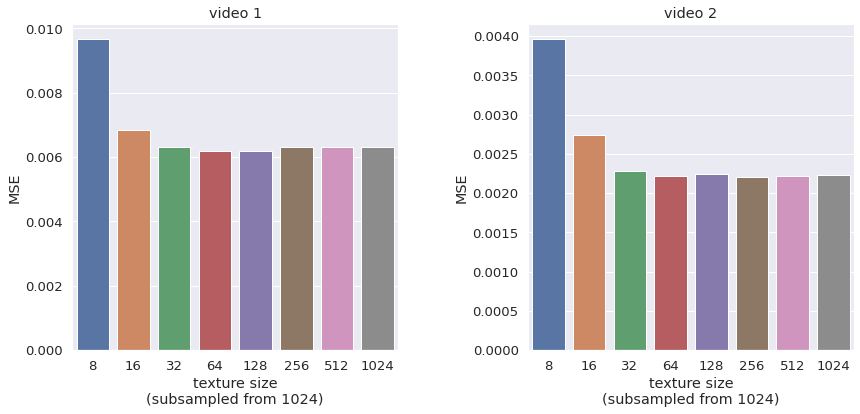

In [7]:
display(Markdown("## Subsampling"))

def subsample_plots():
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    int(measurement['settings']['texture size']),
                    measurement['total MSE'],
                )
                    for measurement in M2
                        if measurement['settings']["video file"] == video_name
                        and measurement['settings']["jitter size"] == "1"
            ],
            columns=["texture size", "total MSE"]
        )



    total_mse_by_texture_size = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }
    
    _, axes = plt.subplots(1, 2)

    sb.barplot(
        x=total_mse_by_texture_size["video 1"]["texture size"],
        y=total_mse_by_texture_size["video 1"]["total MSE"],
        ax=axes[0],
        ci=None,
    )

    axes[0].set_ylabel("MSE")
    axes[0].set_xlabel("texture size\n(subsampled from 1024)")
    axes[0].set_title("video 1")

    sb.barplot(
        x=total_mse_by_texture_size["video 2"]["texture size"],
        y=total_mse_by_texture_size["video 2"]["total MSE"],
        ax=axes[1],
        ci=None,
    )

    axes[1].set_ylabel("MSE")
    axes[1].set_xlabel("texture size\n(subsampled from 1024)")
    axes[1].set_title("video 2")

    plt.subplots_adjust(
        wspace=0.4,
    )

    plt.show()

subsample_plots()

## Jitter

### No jitter VS staggered jitter

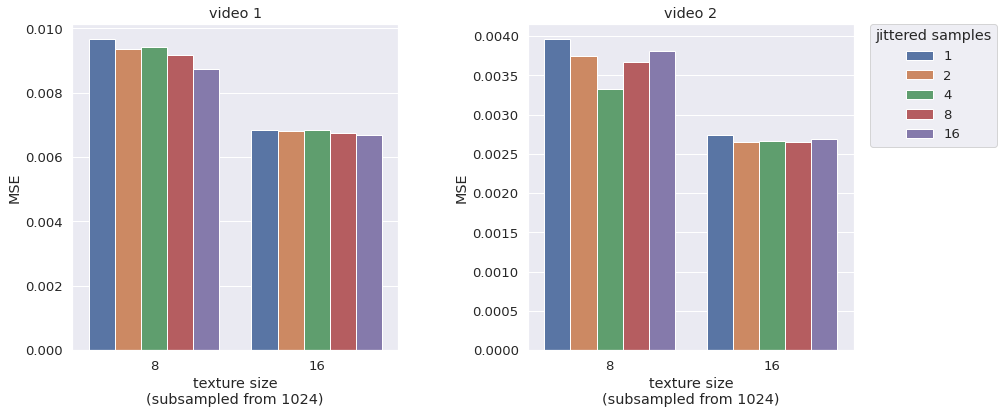

In [8]:
display(Markdown("## Jitter"))

display(Markdown("### No jitter VS staggered jitter"))

def jitter_plots():

    max_texture_size = 16
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    int(measurement['settings']['texture size']),
                    measurement['total MSE'],
                    int(measurement['settings']['jitter size'])
                )
                    for measurement in M2
                        if measurement['settings']["video file"] == video_name
                        and int(measurement['settings']["texture size"]) <= max_texture_size
                        and (
                            measurement['settings']["staggered jitter"] == "Yes"
                            or measurement['settings']["jitter size"] == "1"
                        )
            ],
            columns=["texture size", "total MSE", "jitter size"]
        )



    total_mse_by_texture_size_with_jitter = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }

    _, axes = plt.subplots(1, 2)

    g = sb.barplot(
        data=total_mse_by_texture_size_with_jitter["video 1"],
        x="texture size",
        y="total MSE",
        hue="jitter size",
        ci=None,
        ax = axes[0],
    )

    g.legend().remove()

    axes[0].set_ylabel("MSE")
    axes[0].set_xlabel("texture size\n(subsampled from 1024)")
    axes[0].set_title("video 1")

    g = sb.barplot(
        data=total_mse_by_texture_size_with_jitter["video 2"],
        x="texture size",
        y="total MSE",
        hue="jitter size",
        ci=None,
        ax = axes[1],
    )

    g.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0,
        title="jittered samples"
    )

    axes[1].set_ylabel("MSE")
    axes[1].set_xlabel("texture size\n(subsampled from 1024)")
    axes[1].set_title("video 2")

    plt.subplots_adjust(
        wspace=0.4,
    )

    plt.show()

jitter_plots()

### Staggered VS scanline jitter

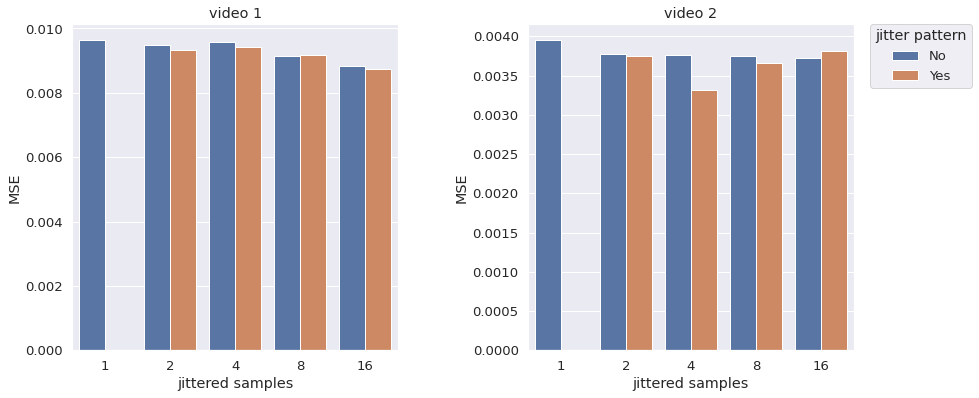

In [9]:
display(Markdown("### Staggered VS scanline jitter"))


def jitter_staggered_vs_scanline_plots():

    texture_size = 8
    
    def load_video(video_name):
        return pd.DataFrame(
            list(
                [
                    (
                        measurement['total MSE'],
                        measurement['settings']['jitter size'],
                        measurement['settings']['staggered jitter']                  
                    )
                    for measurement in M2
                        if measurement['settings']["video file"] == video_name
                        and int(measurement['settings']["texture size"]) == texture_size
                ]
            ),
            columns=["total MSE", "jitter size", "staggered jitter"]
        )

    total_mse_by_texture_size_with_jitter = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }

    _, axes = plt.subplots(1, 2)

    g = sb.barplot(
        data=total_mse_by_texture_size_with_jitter["video 1"],
        x="jitter size",
        y="total MSE",
        hue="staggered jitter",
        ci=None,
        ax = axes[0],
    )

    g.legend().remove()

    axes[0].set_ylabel("MSE")
    axes[0].set_xlabel("jittered samples")
    axes[0].set_title("video 1")

    g = sb.barplot(
        data=total_mse_by_texture_size_with_jitter["video 2"],
        x="jitter size",
        y="total MSE",
        hue="staggered jitter",
        ci=None,
        ax = axes[1],
    )

    g.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0,
        title="jitter pattern"
    )
    axes[1].set_ylabel("MSE")
    axes[1].set_xlabel("jittered samples")
    axes[1].set_title("video 2")

    plt.subplots_adjust(
        wspace=0.4,
    )

    plt.show()

jitter_staggered_vs_scanline_plots()

In [10]:
display(Markdown('# Dataset 3: subsample vs downscale'))

M3 = load_measurements("3. subsample vs downscale")

M3 = sorted(
    M3,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["downscale"],
    )
)

show_measurements_table(M2)

# Dataset 3: subsample vs downscale

video file  |  texture size  |  staggered jitter  |  jitter size  |  MSE
-----------------------------------------------------------------------------
1           |  1024          |  No                |  1            |  0.00631   
1           |  512           |  No                |  1            |  0.00631   
1           |  512           |  No                |  2            |  0.00631   
1           |  512           |  Yes               |  2            |  0.00631   
1           |  256           |  No                |  1            |  0.00631   
1           |  256           |  No                |  2            |  0.00631   
1           |  256           |  Yes               |  2            |  0.00631   
1           |  256           |  No                |  4            |  0.00631   
1           |  256           |  Yes               |  4            |  0.00631   
1           |  128           |  No                |  1            |  0.00620   
1           |  128           |  No               

### Subsample VS downscale

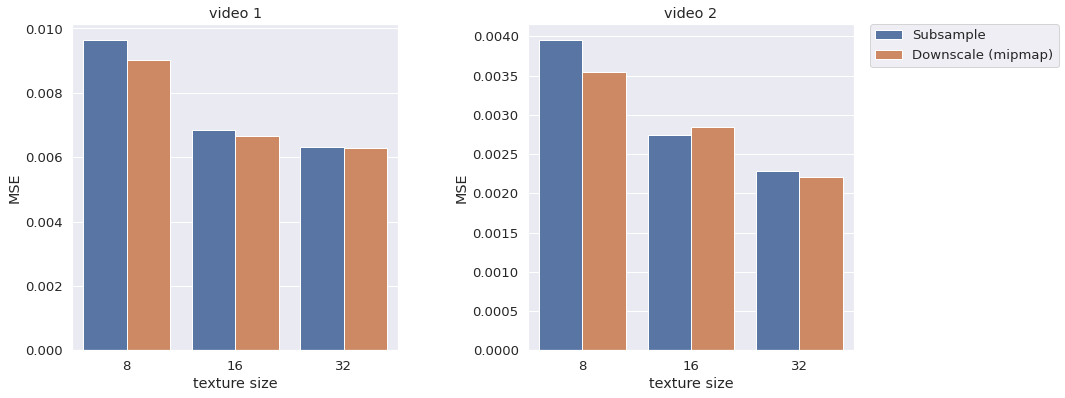

In [11]:
display(Markdown("### Subsample VS downscale"))

def subsample_vs_downscale_plots():

    max_texture_size = 32
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    measurement['total MSE'],
                    int(measurement['settings']['texture size']),
                    
                    "Downscale (mipmap)"
                            if measurement['settings']['downscale'] == "Yes"
                    else "Subsample"     
                )
                    for measurement in M3
                        if measurement['settings']["video file"] == video_name
                        and int(measurement['settings']["texture size"]) <= max_texture_size
            ],
            columns=["total MSE", "texture size", "downscale"]
        )

    total_mse_by_texture_size_with_jitter = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }

    _, axes = plt.subplots(1, 2)

    g = sb.barplot(
        data=total_mse_by_texture_size_with_jitter["video 1"],
        x="texture size",
        y="total MSE",
        hue="downscale",
        ci=None,
        ax = axes[0],
    )

    g.legend().remove()

    axes[0].set_ylabel("MSE")
    axes[0].set_xlabel("texture size")
    axes[0].set_title("video 1")

    g = sb.barplot(
        data=total_mse_by_texture_size_with_jitter["video 2"],
        x="texture size",
        y="total MSE",
        hue="downscale",
        ci=None,
        ax = axes[1],
    )

    g.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0,
    )
    axes[1].set_ylabel("MSE")
    axes[1].set_xlabel("texture size")
    axes[1].set_title("video 2")

    plt.subplots_adjust(
        wspace=0.4,
    )

    plt.show()

subsample_vs_downscale_plots()

In [12]:
display(Markdown("# ToDo measurements"))

display(
    Markdown(
"""
|Measurement|Clusters|Iterations|Texture size|
|----|----|----|----|
|subsampling|🗸|-|🗸|
|downscaling|-|-|🗸|
|jitter|-|-|🗸|
|scanline jitter|-|-|🗸|
|randomize vs freeze empty clusters|-|-|🗸|
|local mimimum check|🗸|-|-|

* Random swap
    * randomize 1 cluster
    * full randomization
    * simple K-Means
* KHM and random swap
    * KM
    * KHM
    * KM + random swap

----

In order to show, that KM does not get stuck in local minimum:

* 12 iterations of KM
* 6 iterations of random swap
* 12 iterations of KHM

**plot MSE and peak MSE**

-----

Use random swap only as a reference to check for local minimum. KHM is clearly superior,
because it does not require additional dispatches and texture reads.

But do make performance benchmarks to show this, and show that KHM achieves similar quality to random swap.

----

It's not MSE, it's variance.
"""
    )
)

# ToDo measurements


|Measurement|Clusters|Iterations|Texture size|
|----|----|----|----|
|subsampling|🗸|-|🗸|
|downscaling|-|-|🗸|
|jitter|-|-|🗸|
|scanline jitter|-|-|🗸|
|randomize vs freeze empty clusters|-|-|🗸|
|local mimimum check|🗸|-|-|

* Random swap
    * randomize 1 cluster
    * full randomization
    * simple K-Means
* KHM and random swap
    * KM
    * KHM
    * KM + random swap

----

In order to show, that KM does not get stuck in local minimum:

* 12 iterations of KM
* 6 iterations of random swap
* 12 iterations of KHM

**plot MSE and peak MSE**

-----

Use random swap only as a reference to check for local minimum. KHM is clearly superior,
because it does not require additional dispatches and texture reads.

But do make performance benchmarks to show this, and show that KHM achieves similar quality to random swap.

----

It's not MSE, it's variance.


In [13]:
display(Markdown('# Dataset 1: subsampling'))

M1 = load_measurements("1. subsampling")

M2 = sorted(
    M2,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
    )
)


show_measurements_table(M1)

# Dataset 1: subsampling

video file  |  texture size  |  number of clusters  |  MSE
---------------------------------------------------------------
1           |  8             |  4                   |  0.01820   
1           |  8             |  6                   |  0.00941   
1           |  8             |  8                   |  0.00653   
1           |  8             |  12                  |  0.00387   
1           |  8             |  16                  |  0.00256   
1           |  16            |  4                   |  0.01464   
1           |  16            |  6                   |  0.00672   
1           |  16            |  8                   |  0.00478   
1           |  16            |  12                  |  0.00281   
1           |  16            |  16                  |  0.00182   
1           |  32            |  4                   |  0.01468   
1           |  32            |  6                   |  0.00628   
1           |  32            |  8                   |  0.00435   
1           |  32  

## Plots

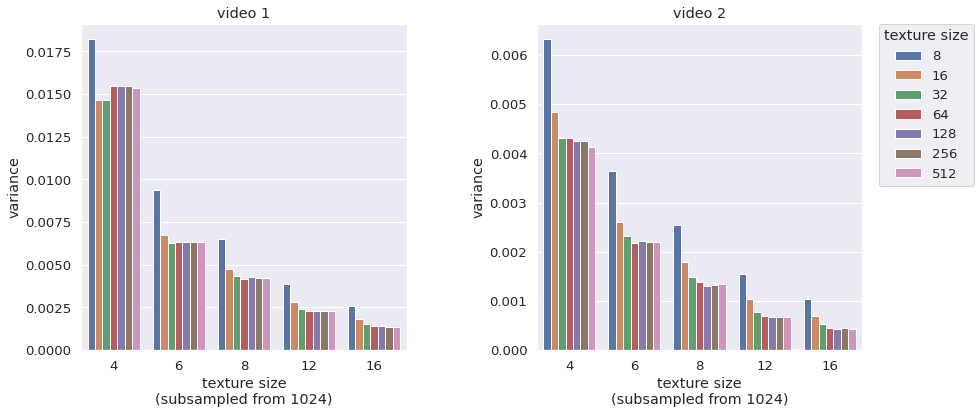

In [14]:
display(Markdown("## Plots"))

def subsample_plots():
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    int(measurement['settings']['texture size']),
                    measurement['total MSE'],
                    measurement['settings']['number of clusters'],
                )
                    for measurement in M1
                        if measurement['settings']["video file"] == video_name
            ],
            columns=["texture size", "total MSE", "number of clusters"]
        )



    total_mse_by_texture_size = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }
    
    _, axes = plt.subplots(1, 2)

    g = sb.barplot(
        x=total_mse_by_texture_size["video 1"]["number of clusters"],
        y=total_mse_by_texture_size["video 1"]["total MSE"],
        ax=axes[0],
        hue=total_mse_by_texture_size["video 1"]["texture size"],
        ci=None,
    )
    
    g.legend().remove()

    axes[0].set_ylabel("variance")
    axes[0].set_xlabel("texture size\n(subsampled from 1024)")
    axes[0].set_title("video 1")

    g = sb.barplot(
        x=total_mse_by_texture_size["video 2"]["number of clusters"],
        y=total_mse_by_texture_size["video 2"]["total MSE"],
        ax=axes[1],
        hue=total_mse_by_texture_size["video 2"]["texture size"],
        ci=None,
    )

    axes[1].set_ylabel("variance")
    axes[1].set_xlabel("texture size\n(subsampled from 1024)")
    axes[1].set_title("video 2")
    
    g.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0,
        title="texture size"
    )

    plt.subplots_adjust(
        wspace=0.4,
    )

    plt.show()

subsample_plots()

In [15]:
display(Markdown('# Dataset 2: scaling vs subsampling'))

M2 = load_measurements("2. scaling vs subsampling")

M2 = sorted(
    M2,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["downscale"],
    )
)


show_measurements_table(M2)

# Dataset 2: scaling vs subsampling

video file  |  texture size  |  downscale  |  MSE
------------------------------------------------------
1           |  512           |  No         |  0.00631   
1           |  512           |  Yes        |  0.00631   
1           |  256           |  No         |  0.00631   
1           |  256           |  Yes        |  0.00630   
1           |  128           |  No         |  0.00631   
1           |  128           |  Yes        |  0.00630   
1           |  64            |  No         |  0.00634   
1           |  64            |  Yes        |  0.00631   
1           |  32            |  No         |  0.00628   
1           |  32            |  Yes        |  0.00629   
1           |  16            |  No         |  0.00672   
1           |  16            |  Yes        |  0.00670   
1           |  8             |  No         |  0.00941   
1           |  8             |  Yes        |  0.00892   
2           |  512           |  No         |  0.00219   
2           |  512           |  Yes     

## Plots

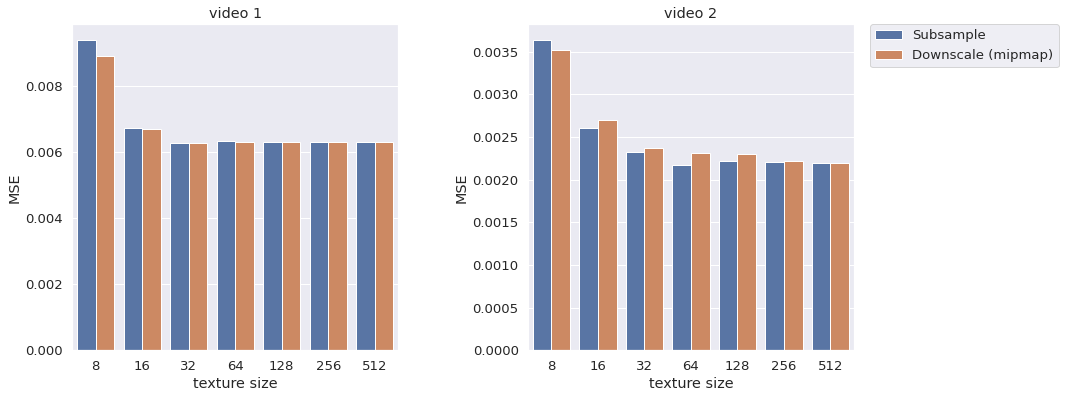

In [21]:
display(Markdown("## Plots"))

def subsample_vs_downscale_plots():
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    measurement['total MSE'],
                    int(measurement['settings']['texture size']),
                    
                    "Downscale (mipmap)"
                            if measurement['settings']['downscale'] == "Yes"
                    else "Subsample"     
                )
                    for measurement in M2
                        if measurement['settings']["video file"] == video_name
            ],
            columns=["total MSE", "texture size", "downscale"]
        )

    total_mse_by_texture_size_with_jitter = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }

    _, axes = plt.subplots(1, 2)

    g = sb.barplot(
        data=total_mse_by_texture_size_with_jitter["video 1"],
        x="texture size",
        y="total MSE",
        hue="downscale",
        ci=None,
        ax = axes[0],
    )

    g.legend().remove()

    axes[0].set_ylabel("MSE")
    axes[0].set_xlabel("texture size")
    axes[0].set_title("video 1")

    g = sb.barplot(
        data=total_mse_by_texture_size_with_jitter["video 2"],
        x="texture size",
        y="total MSE",
        hue="downscale",
        ci=None,
        ax = axes[1],
    )

    g.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0,
    )
    axes[1].set_ylabel("MSE")
    axes[1].set_xlabel("texture size")
    axes[1].set_title("video 2")

    plt.subplots_adjust(
        wspace=0.4,
    )

    plt.show()

subsample_vs_downscale_plots()

In [20]:
display(Markdown('# Dataset 3: Jitter'))

M2 = load_measurements("2. scaling vs subsampling")

M2 = sorted(
    M2,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["downscale"],
    )
)


show_measurements_table(M2)

# Dataset 3: Jitter

video file  |  texture size  |  downscale  |  MSE
------------------------------------------------------
1           |  512           |  No         |  0.00631   
1           |  512           |  Yes        |  0.00631   
1           |  256           |  No         |  0.00631   
1           |  256           |  Yes        |  0.00630   
1           |  128           |  No         |  0.00631   
1           |  128           |  Yes        |  0.00630   
1           |  64            |  No         |  0.00634   
1           |  64            |  Yes        |  0.00631   
1           |  32            |  No         |  0.00628   
1           |  32            |  Yes        |  0.00629   
1           |  16            |  No         |  0.00672   
1           |  16            |  Yes        |  0.00670   
1           |  8             |  No         |  0.00941   
1           |  8             |  Yes        |  0.00892   
2           |  512           |  No         |  0.00219   
2           |  512           |  Yes     